In [10]:
import matplotlib
import matplotlib.pyplot as plt

import jax
import jax.numpy as np
from jax.random import PRNGKey

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import pandas as pd

from models import SIR_stochastic, SEIR_stochastic, plot_samples

# Load and Prep Data

In [11]:
import jhu
import covidtracking
import states


def load_data():

    # world data
    world = jhu.load_world()

    pop = {
        'Italy': 60.48e6,
        'US': 3.27e8,
    }

    data = {
        'Italy': world.Italy.tot,
        'US': world.US.tot
    }

    # US state data
    US = covidtracking.load_us()
    traits = states.uga_traits()

    state_pop = { k: traits.totalpop[k] for k in traits.index }
    state_data = { k: US[k] for k in US.columns.unique(level=0) }

    # combine them
    data = dict(data, **state_data)
    pop = dict(pop, **state_pop)
    
    return data, pop

# Run Inference

In [24]:
import sys


data, pop = load_data()
#places = ['Italy', 'US', 'WA', 'NY', 'MA']
#places = ['NY', 'WA']

place = 'NY'

start = pd.Timestamp('2020-03-04')
confirmed = data[place].confirmed[start:]
start = confirmed.index.min()

T = len(confirmed)
N = pop[place]

args = {
    'N': N,
    'T': T,
    'drift_scale': 2e-1,
    'det_conc': 100,
}

if model == 'SEIR':
    prob_model = SEIR_stochastic
elif model == 'SIR':
    prob_model = SIR_stochastic
else:
    raise ValueError("Bad model")

kernel = NUTS(prob_model,
              init_strategy = numpyro.infer.util.init_to_median())

mcmc = MCMC(kernel, 
            num_warmup=1000, 
            num_samples=1000, 
            num_chains=1)

mcmc.run(jax.random.PRNGKey(2), 
         obs = confirmed.values,
         **args)

mcmc.print_summary()
mcmc_samples = mcmc.get_samples()

# Posterior predictive samples for visualization
post_pred = Predictive(prob_model, posterior_samples = mcmc_samples)
post_pred_samples = post_pred(PRNGKey(2), T_future=100, **args)

# Save samples
filename = f'out/{place}_samples.npz'
np.savez(filename, mcmc_samples=mcmc_samples, post_pred_samples=post_pred_samples)

# Write diagnostics to file
filename = f'out/{place}_summary.txt'
orig_stdout = sys.stdout
with open(filename, 'w') as f:
    sys.stdout = f
    mcmc.print_summary()

sys.stdout = orig_stdout

sample: 100%|██████████| 2000/2000 [02:03<00:00, 16.16it/s, 511 steps of size 1.16e-02. acc. prob=0.91] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        E0    247.98    134.29    214.34     82.08    427.58    257.24      1.00
        I0     18.75      4.49     18.08     12.10     25.23    381.44      1.00
   beta[0]      2.10      0.89      1.92      0.81      3.47    347.98      1.00
   beta[1]      2.12      0.87      1.94      0.86      3.46    417.74      1.00
   beta[2]      2.04      0.84      1.87      0.88      3.23    476.40      1.00
   beta[3]      1.94      0.80      1.74      0.80      3.04    444.69      1.00
   beta[4]      1.92      0.85      1.72      0.76      2.99    395.98      1.00
   beta[5]      2.01      0.92      1.81      0.78      3.18    343.28      1.00
   beta[6]      2.23      1.09      1.97      0.95      3.64    383.06      1.00
   beta[7]      2.57      1.29      2.32      0.90      4.06    365.85      1.00
   beta[8]      3.00      1.47      2.68      1.14      4.77    361.91      1.00
   beta[9]      3.43      1

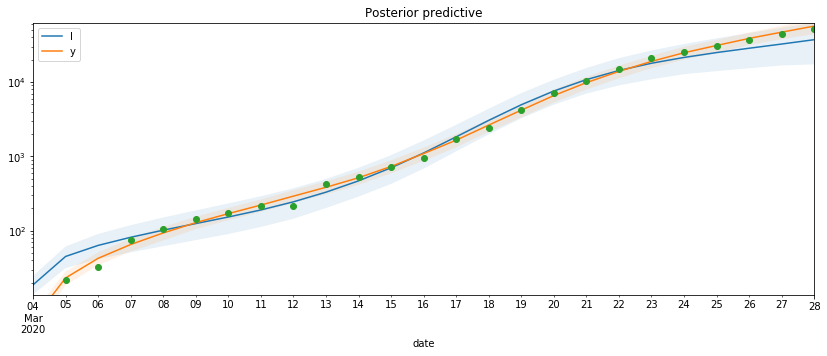

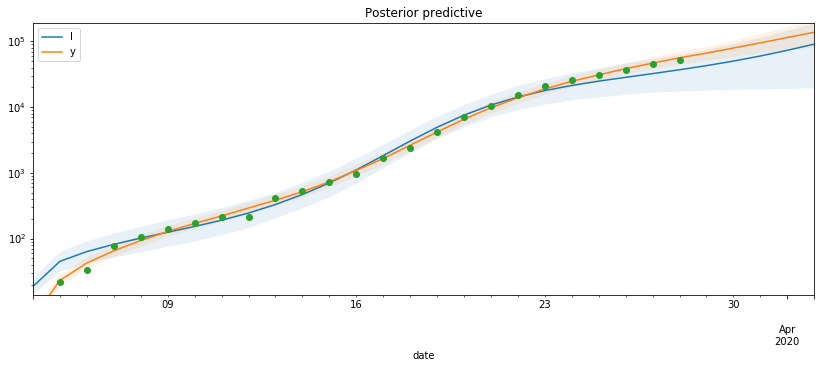

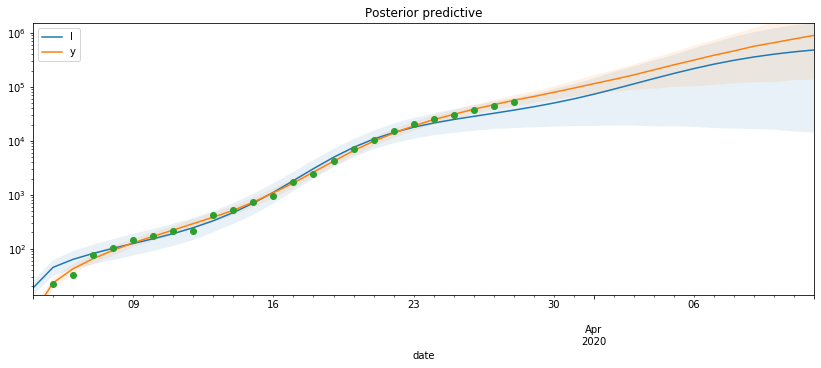

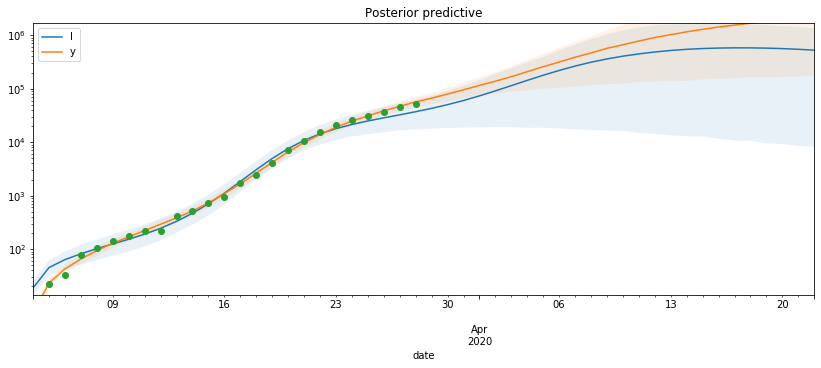

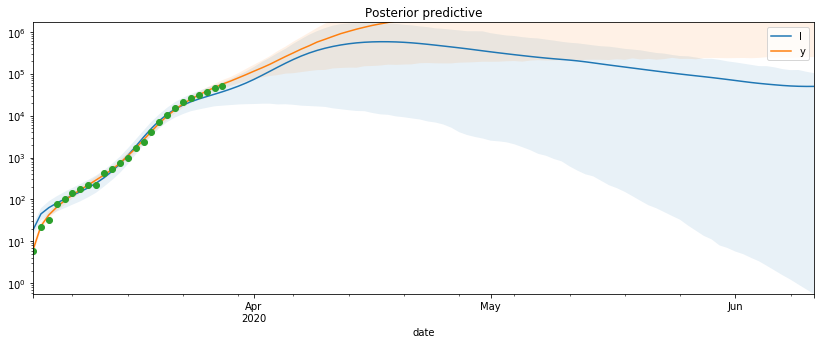

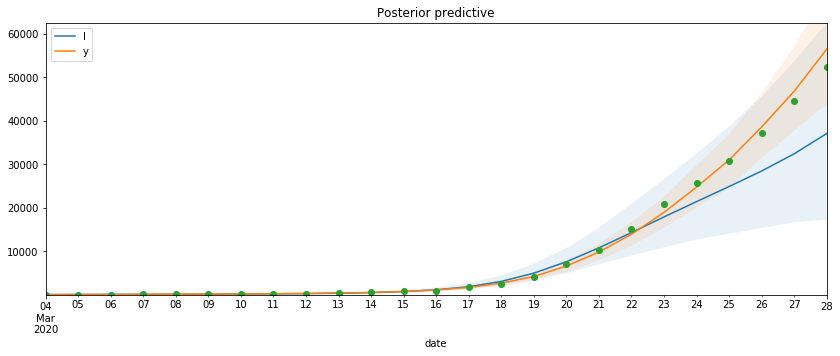

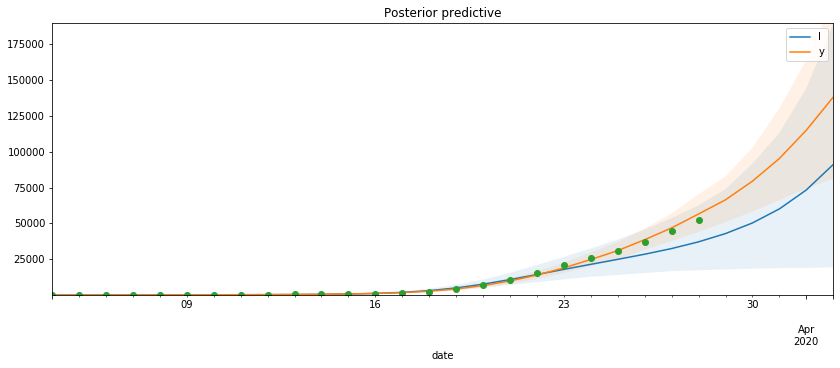

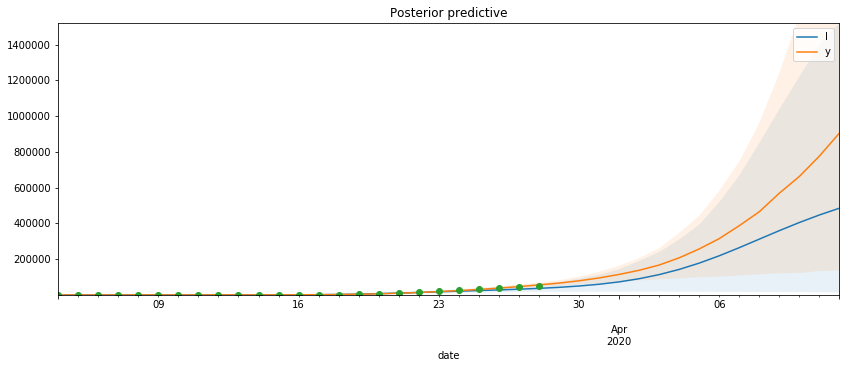

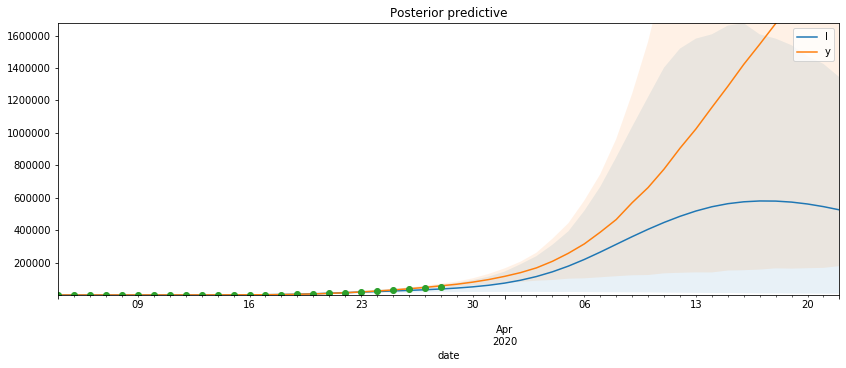

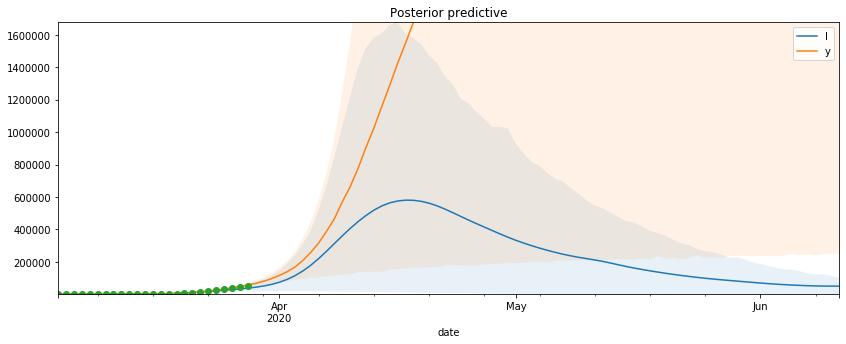

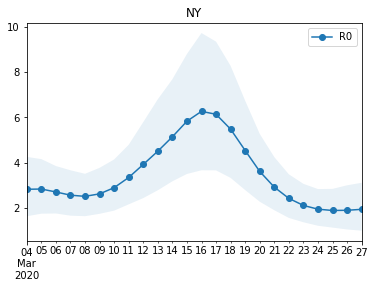

In [25]:

data, pop = load_data()

start = '2020-03-04'
#places = ['Italy', 'US', 'WA', 'NY', 'MA']
places = ['NY']

for place in places:
    
    confirmed = data[place].confirmed[start:]
    start_ = confirmed.index.min()

    T = len(confirmed)
    N = pop[place]

    filename = f'out/{place}_samples.npz'
    x = np.load(filename, allow_pickle=True)
    mcmc_samples = x['mcmc_samples'].item()
    post_pred_samples = x['post_pred_samples'].item()

    
    # Inspect and Save Results

    for scale in ['log', 'lin']:
        for T in [len(confirmed), 30, 40, 50, 100]:

            t = pd.date_range(start=start_, periods=T, freq='D')

            fig, ax = plt.subplots(figsize=(14,5))
            plot_samples(post_pred_samples, T=T, t=t, ax=ax, plot_fields=['I', 'y'], model=model)
            plt.title('Posterior predictive')

            confirmed.plot(style='o')

            if scale == 'log':
                plt.yscale('log')

            filename = f'figs/{place}_predictive_scale_{scale}_T_{T}.png'
            plt.savefig(filename)

            plt.show()

    # Compute average R0 over time
    gamma = mcmc_samples['gamma'][:,None]
    beta = mcmc_samples['beta']
    t = pd.date_range(start=start_, periods=beta.shape[1], freq='D')
    R0 = beta/gamma

    pi = np.percentile(R0, (10, 90), axis=0)
    df = pd.DataFrame(index=t, data={'R0': R0.mean(axis=0)})
    df.plot(style='-o')
    plt.fill_between(t, pi[0,:], pi[1,:], alpha=0.1)

    filename = f'figs/{place}_R0.png'
    plt.savefig(filename)

    plt.title(place)
    plt.show()

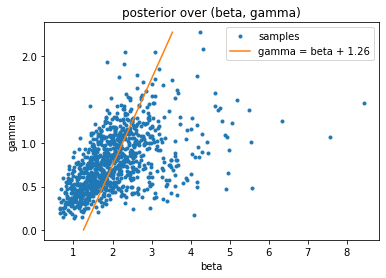

R0: 2.9294224


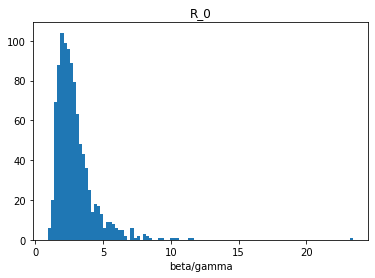

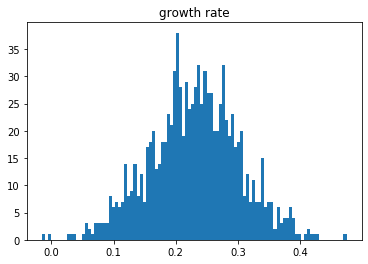

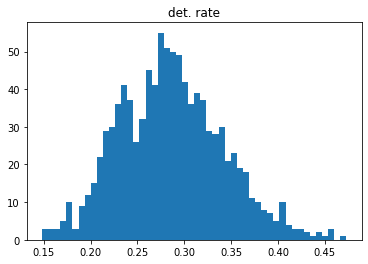

In [44]:
from compartment import SIRModel, SEIRModel

save = False

beta = mcmc_samples['beta0']
#gamma = np.broadcast_to(mcmc_samples['gamma'][:,None], beta.shape)
gamma = mcmc_samples['gamma']
plt.plot(beta, gamma, '.')
offset = (beta-gamma).mean()

plt.plot([0.+offset, gamma.max()+offset], [0., gamma.max()])
plt.xlabel('beta')
plt.ylabel('gamma')
plt.title('posterior over (beta, gamma)')
plt.legend(['samples', r'gamma = beta + ' + f'{offset:.2f}'])
if save:
    filename = f'figs/{place}_beta_gamma.pdf'
    plt.savefig(filename)
plt.show()


plt.hist(beta/gamma, bins=100)
plt.title('R_0')
plt.xlabel('beta/gamma')
R_0_mean = np.mean(beta/gamma)
print("R0:", R_0_mean)
if save:
    filename = f'figs/{place}_R0.pdf'
    plt.savefig(filename)
plt.show()


growth_rate = SEIRModel.growth_rate((mcmc_samples['beta0'], 
                                     mcmc_samples['sigma'],
                                     mcmc_samples['gamma']))
plt.hist(growth_rate, bins=100)
plt.title('growth rate')
if save:
    filename = f'figs/{place}_growth_rate.pdf'
    plt.savefig(filename)
plt.show()

plt.hist(mcmc_samples['det_rate'], bins=50)
plt.title('det. rate')
if save:
    filename = f'figs/{place}_growth_rate.pdf'
    plt.savefig(filename)
plt.show()


## Tests

In [ ]:
def test_prior(i, log_scale=False, **kwargs):
    with numpyro.handlers.seed(rng_seed=i):
        beta, x, y, obs_rate = SIR_stochastic(**kwargs)
        
    T = len(x)
    ts = np.arange(T)
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    
    l1 = ax1.plot(ts, x)    
    l2 = ax2.plot(ts, y, 'x', color='r')
        
    plt.legend(l1 + l2, ['S', 'I', 'R', 'C', 'y'])
    
    ax1.set_ylabel('compartment count')
    ax2.set_ylabel('observed cases')

    if log_scale:
        ax1.set_yscale('log')
        ax2.set_yscale('log')
    
    ylim = np.array(ax1.get_ylim())
    ax2.set_ylim(obs_rate * ylim )
    
    plt.show()

def test_prior_predictive():
    T = 100
    T_future = 100
    N = 1e6
    predictive = Predictive(SIR_stochastic, 
                            posterior_samples = {}, 
                            num_samples=100)

    samples = predictive(PRNGKey(2), T=T, T_future=100, N=N)

    plot_samples(samples, T=200, plot_fields=['I', 'y'])
    plt.title('Prior predictive')
    plt.yscale('log') 
    plt.show()
    
run_tests = True
    
if run_tests:
    for i in range(5):
        test_prior(i, log_scale=False, T=50, T_future=50, N=1e8)
        
    test_prior_predictive()

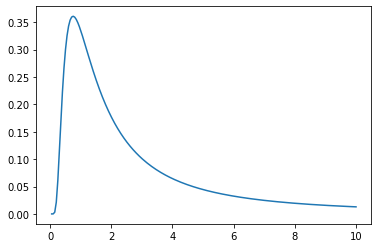

In [11]:
d = dist.Gamma(1, 1 * 1.5)
e = dist.TransformedDistribution(d, dist.transforms.PowerTransform(-1))
x = np.linspace(0, 10, 200)
plt.plot(x, np.exp(e.log_prob(x)))



In [42]:
mcmc_samples = None

place = 'WA'
filename = f'out/{place}_samples.npz'
x = np.load(filename, allow_pickle=True)
#print(x['arr_0']['E0'])
mcmc_samples = x['arr_0'].item()
post_pred_samples = x['arr_0'].item()

mcmc_samples['E0']

array([8.66874619e+01, 4.15219696e+02, 4.45294373e+02, 2.56993042e+02,
       7.04531937e+01, 1.18157928e+02, 1.36333282e+02, 1.07267029e+02,
       8.06847839e+01, 8.15182419e+01, 8.50297852e+01, 1.01856270e+02,
       1.20759430e+02, 1.11948647e+02, 1.02471603e+02, 8.55147476e+01,
       4.72280006e+01, 2.64801849e+02, 4.25228485e+02, 1.49566147e+02,
       7.14774170e+01, 2.46033691e+02, 1.93305496e+02, 1.57670837e+02,
       1.99327652e+02, 3.03032928e+02, 1.67519287e+02, 3.97491730e+02,
       1.51864357e+01, 7.93717117e+01, 1.51606049e+02, 1.44905502e+02,
       2.77630524e+02, 8.47063522e+01, 4.99812088e+01, 5.57977142e+01,
       7.15447006e+01, 2.27100334e+01, 4.41022491e+01, 1.07956108e+02,
       5.55965576e+02, 2.58322235e+02, 4.25230896e+02, 1.67635040e+02,
       1.59257479e+01, 5.08653526e+01, 4.43552132e+01, 7.02877808e+01,
       7.97777634e+01, 9.82648163e+01, 2.54315414e+01, 1.59228363e+02,
       1.51452240e+02, 6.13588982e+01, 1.80332428e+02, 8.58205719e+01,
      

In [33]:
print(mcmc_samples['x'])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices